In [1]:
import pickle
import pandas
import numpy as np
from datetime import datetime
import math

import keras
from keras.preprocessing import image
from keras import applications
from keras.models import Sequential
from keras.applications import vgg16
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers import Conv2D, Conv3D,Input, ZeroPadding3D, Reshape,LSTM
from keras.layers.convolutional import Convolution2D, Convolution3D, MaxPooling2D, ZeroPadding2D,ZeroPadding3D 
from keras.layers.core import Reshape
import os
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import CSVLogger
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.optimizers import SGD
from keras.layers import Merge 
import numpy as np
import keras
import keras.backend as K
from keras.callbacks import LambdaCallback
from keras import regularizers
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# X = np.load("train_X_normalized_lstm_delta.pkl.npy")
# Y = np.load("train_Y_normalized_lstm_delta.pkl.npy")
# X_test = np.load("test_X_normalized_lstm_delta.pkl.npy")
# Y_test = np.load("test_Y_normalized_lstm_delta.pkl.npy")

# de_norm_test = np.load("de_norm_lstm_delta_test.pkl.npy")
# unnormalized_Y = np.load("unnormalized_Y_test_v2.pkl.npy")
# Y_reg = np.load("test_Y_normalized_lstm_regression_v2.pkl.npy")
# X = np.load("train_X_normalized_lstm_classification.pkl.npy")
# Y = np.load("train_Y_normalized_lstm_classification.pkl.npy")

In [3]:
## Preprocessing
Inf = math.inf
with open('BTC-USD-60.pkl', 'rb') as f:
    data = pickle.load(f)

# sort the data based on ascending-order of time
data = data.sort_values(by=['time'])

# save the original valuse for the fulture delta calculation
data_original = data
data_original = data_original[data_original.close > 200]
close_price = np.array(data_original.close)

# drop time
data = data[data.close > 200]
time = np.array(data.time)
data = data.drop('time', 1)

# get all delta y's
y_distribution = []
for i in range(len(close_price) - 60):       
    if time[i+60] - time[i] == 60*60:
          y_distribution.append( (close_price[i + 60] - close_price[i + 59]) / close_price[i + 59] * 100)  

# since <0 and >0 buckets are not symetrical, we can do it separately
y_distribution = sorted(y_distribution)
print("# of all y:",np.shape(y_distribution))
y_distribution = list(filter(lambda a: a != 0, y_distribution))
y_pos = list(filter(lambda a: a > 0, y_distribution))
print("# of positive y:",np.shape(y_pos))
y_neg = list(filter(lambda a: a <0, y_distribution))
print("# of negative y:",np.shape(y_neg))

# of all y: (810567,)
# of positive y: (349583,)
# of negative y: (316705,)


In [19]:

def normalize_windows(window_data):
    window_data = (window_data / window_data[0]) - 1 
    return window_data

def switch(delta,train_Y,buckets):# separate y values according to bucket separating values and put Y in corresponding bucket
    temp = [0]*len(buckets)
    if delta == 0:
        temp[len(buckets)//2] = 1

    else:    
        for i in range(len(buckets)-1):
            if delta >= buckets[i] and delta < buckets[i+1]:
                # because ==0 itself is a bucket, all >0 buckets will need index+1
                if delta > 0:
                    temp[i+1] = 1
                if delta < 0:
                    temp[i] = 1
                
    train_Y.append(temp)
    return train_Y


# Recursively get bucket separating values
def bucket_separate(nBuckets,bucket_list,y_distribution):
    mid = len(y_distribution)//2 # median index of input y_distribution list
    if nBuckets % 2 == 1:
        print("number of buckets must be (2^n+1) greater than 3")

    elif nBuckets == 2:
        bucket_list.append(y_distribution[mid])

    else:
        bucket_list.append(y_distribution[mid])
        bucket_list = bucket_separate(nBuckets/2,bucket_list,y_distribution[:mid])#left
        bucket_list = bucket_separate(nBuckets/2,bucket_list,y_distribution[mid:])#right
    bucket_list = sorted(bucket_list)

    return bucket_list

def lstm_preprocess(data, close_price, time, bucket_list,test_pct):
    window_length = 60
    A = np.array(data.low)
    B = np.array(data.high)
    C = np.array(data.open)
    D = np.array(data.close)
    E = np.array(data.volume)
    i = 0
    train_X = []
    train_Y = []
    test_X = []
    test_Y = []
    true_Y_test = []
    de_norm_train = []
    de_norm_test = []
    error = 0
    

    
    while i < len(C) - window_length:
         
        if time[i+window_length] - time[i] == window_length*60:
            temp = []
            copy_A = np.copy(A[i:i+window_length+1])
            copy_B = np.copy(B[i:i+window_length+1])
            copy_C = np.copy(C[i:i+window_length+1])
            copy_D = np.copy(D[i:i+window_length+1])
            copy_E = np.copy(E[i:i+window_length+1])
             
            normalized_temp_A = normalize_windows(copy_A)
            normalized_temp_B = normalize_windows(copy_A)
            normalized_temp_C = normalize_windows(copy_A)
            normalized_temp_D = normalize_windows(copy_A)
            normalized_temp_E = normalize_windows(copy_A)
            #print(len(normalized_temp_D[:-1]))
            temp.append(normalized_temp_A[:-1])
            temp.append(normalized_temp_B[:-1])
            temp.append(normalized_temp_C[:-1])
            temp.append(normalized_temp_D[:-1])
            temp.append(normalized_temp_E[:-1])
#         temp.append(year[i:i+60])
#         temp.append(hour[i:i+60])
            
            delta = (close_price[i + 60] - close_price[i + 59]) / close_price[i + 59] * 100
            
            # percentage of test
            if test_pct == 0:
                test = Inf
            else:
                test = (1/test_pct)
            if i%test == 0 :
                test_X.append(temp)
                true_Y_test.append(close_price[i + 60])
                # like switch command in C, decide which bucket we should label.
                test_Y = switch(delta,test_Y,bucket_list)
                de_norm_test.append([copy_A[0], copy_B[0], copy_C[0], copy_D[0], copy_E[0]])
                
            else:
                train_X.append(temp)                       
                # like switch command in C, decide which bucket we should label.
                train_Y = switch(delta,train_Y,bucket_list)
                de_norm_train.append([copy_A[0], copy_B[0], copy_C[0], copy_D[0], copy_E[0]])
            i += 1
        else:
            i = i + 60
    
    
    

        
    train_X = np.transpose(train_X, (0,2,1))   
    train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], -1)    
    train_Y = np.array(train_Y)
    # transform testsets if they are not empty!
    if test_pct != 0:
        test_X = np.transpose(test_X, (0,2,1))
        test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], -1)
        test_Y = np.array(test_Y)
        de_norm_test = np.array(de_norm_test)
        de_norm_test=de_norm_test[:,3]
        de_norm_test.reshape(de_norm_test.shape[0], -1)
    
    return train_X, train_Y, test_X, test_Y, de_norm_train, de_norm_test, true_Y_test


In [5]:
# # test if bucket separation is working
# nBuckets = 33

# buckets = bucket_separate((nBuckets-1)/2,[-Inf,0,Inf],y_neg)
# buckets = bucket_separate((nBuckets-1)/2,buckets,y_pos)

# print(buckets)

# train_X, train_Y, test_X, test_Y, de_norm_train, de_norm_test, true_Y_test = lstm_preprocess(data, close_price, time, buckets)
# count = np.sum(train_Y,axis = 0)
# print(count)

In [12]:
def mse_pred(y_true,y_pred, de_norm_test, de_norm_flag, baskets):
    se = 0
    # change -inf and inf into min and max, as boundaries.
    baskets[0] = np.min(y_neg) 
    baskets[-1]= np.max(y_pos)
    nBuckets = len(baskets)
    
    #categories is a vector containing the mid points of each bucket
    categories = np.array(baskets) #=0
    for i in range(nBuckets//2): #<0
        categories[i] = (baskets[i]+baskets[i+1])/2
    for i in range((nBuckets+1)//2,nBuckets-1): #>0
        categories[i] = (baskets[i]+baskets[i+1])/2
        
    #de_norm_flag is to set whether or not to convert to original value     
    if de_norm_flag:
        pred = de_norm_test*(categories[np.argmax(y_pred,axis = 1)]+1)
    else:
        pred = categories[np.argmax(y_pred,axis = 1)]
    mse = np.sum(abs(1-pred/y_true)**2)
    print("mean squared error equivalent in test set is", mse)
    return mse,pred


In [7]:
def build_model(X,nBuckets):
    model = Sequential()

    model.add(LSTM(512,
        input_shape=(X.shape[1],X.shape[2]),
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        512,
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(nBuckets, activation = 'softmax')) ############ change dense layer node number to number of baskets.
    #Adm = keras.optimizers.Adam(lr = 0.001)
    #model.compile(loss="categorical_crossentropy", optimizer='Adam', metrics=['categorical_accuracy'])
    model.compile(loss="categorical_crossentropy", optimizer='sgd', metrics=['accuracy'])
    # K.tensorflow_backend._get_available_gpus()
    return model


In [29]:
# # Test switch function
# nBuckets = 17
# bucket_list = bucket_separate((nBuckets-1)/2,[-Inf,0,Inf],y_neg)
# bucket_list = bucket_separate((nBuckets-1)/2,bucket_list,y_pos)
# print(bucket_list)
# #train_X, train_Y, test_X, test_Y, de_norm_train, de_norm_test, true_Y_test = lstm_preprocess(data, close_price, time, nBucket)
# y = []
# y = switch(-0.015,[],bucket_list)
# print(y)

[-inf, -0.1923474663909011, -0.10179765402679075, -0.058860596080899344, -0.03402089721958688, -0.01686156201865129, -0.005816104094304639, -0.00136163723260725, 0, 0.0014415609221652109, 0.006531891962501, 0.016997151606364908, 0.032631727443852246, 0.05479735318444713, 0.09217391304347498, 0.17092387418368465, inf]
[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [20]:
for n in range(1,10):
    nBuckets = 2 ** n + 1
    
    # get buckets separating values in a list 
    print("nBuckets:", nBuckets)
    if nBuckets == 3:
        bucket_list = [-Inf,0,Inf]
    else:
        bucket_list = bucket_separate((nBuckets-1)/2,[-Inf,0,Inf],y_neg)
        bucket_list = bucket_separate((nBuckets-1)/2,bucket_list,y_pos)
    print(bucket_list)

    train_X, train_Y, test_X, test_Y, de_norm_train, de_norm_test, true_Y_test = \
    lstm_preprocess(data, close_price, time, bucket_list, 0)
    
    model = build_model(train_X,nBuckets)
    model.summary()
    res = model.fit(train_X, train_Y,batch_size=512, epochs=5,verbose=1, shuffle=True,validation_split = 0.1)
    
    # evaluate on test set, print [loss, accuracy]
    #test_result = model.evaluate(test_X, test_Y)
    
    # evaluate on test set, print [loss, accuracy]
    test_result = model.evaluate(test_X, test_Y)
    print(test_result)
    
    # evaluate on test set again, print equivalent
    Y_pred = model.predict(test_X)
    mse,pred = mse_pred(true_Y_test,Y_pred,de_norm_test,False,bucket_list)
    print(mse)

nBuckets: 3
[-inf, 0, inf]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 60, 512)           1060864   
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 512)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 3,161,603
Trainable params: 3,161,603
Non-trainable params: 0
_________________________________________________________________
Train on 700471 samples, validate on 77831 samples
Epoch 1/5
700471/700471 [=============================

KeyboardInterrupt: 

In [51]:
model.save("lstm_1_delta.h5")

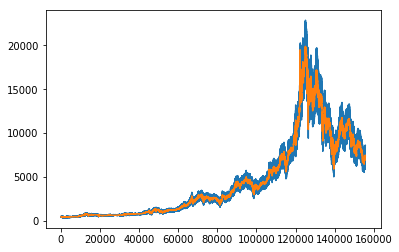

In [93]:
import matplotlib.pyplot as plt
t = np.arange(0,pred.shape[0])
plt.plot(t, pred, true_Y_test)
plt.show()

In [13]:
mse,pred = mse_pred(true_Y_test,Y_pred,de_norm_test,False,bucket_list)
print(mse)

mean squared error equivalent in test set is 77831.0
77831.0
